# Example of automatic fitting of anti-crossing

Pieter Eendebak <pieter.eendebak@tno.nl>

Import the modules used in this program:

In [3]:
import sys, os, time
import qcodes
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import scipy.optimize
import cv2
import qtt
from qtt.deprecated import linetools

from qtt.deprecated.linetools import createCross, semiLine, createH, findCrossTemplate, evaluateCross, fitModel
from qtt.deprecated import tunnelbarrier
from qtt.legacy import straightenImage, fixReversal, cleanSensingImage, showIm

from qcodes.data.hdf5_format import HDF5Format

## Load dataset

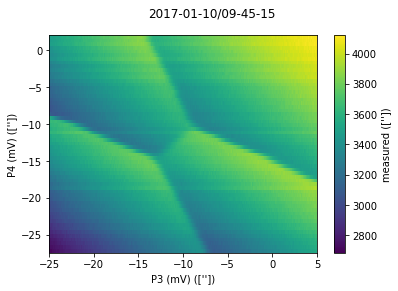

In [4]:
exampledatadir=os.path.join(qtt.__path__[0], 'exampledata')

qcodes.DataSet.default_io = qcodes.DiskIO(exampledatadir)
data = qcodes.load_data('2017-01-10/09-45-15', formatter=HDF5Format())

qtt.scans.plotData(data, fig=10)

## Pre-process image to a honeycomb

 checkReversal: 1 (mval 3532.8, thr 3501.9)
straightenImage: fx 0.1294 fy 2.0000
straightenImage: result mvx 0.2500 mvy 0.2500


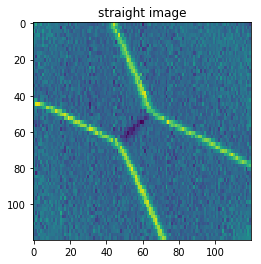

In [5]:
im, tr = qtt.data.dataset2image(data)
imextent = tr.scan_image_extent()
mpl_imextent =tr.matplotlib_image_extent()
istep=.25

im = fixReversal(im, verbose=1)
imc = cleanSensingImage(im, sigma=0.93)
imx, (fw, fh, mvx, mvy, Hstraight) = straightenImage(imc, imextent, mvx=istep, verbose=2) 

imx = imx.astype(np.float64)*(100./np.percentile(imx, 99)) # scale image

showIm(imx, fig=100, title='straight image')

## Initial input

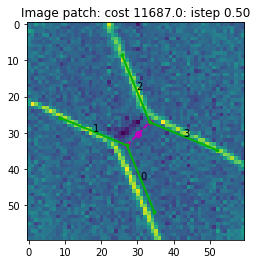

In [6]:
istepmodel = .5
ksizemv = 31
samplesize = [int(ksizemv / istepmodel), int(ksizemv / istepmodel)]
param0 = [(imx.shape[0] / 2 + .5) * istep, (imx.shape[0] / 2 + .5) * istep, istep* 9., 1.17809725, -2.74889357, 4.3196899, 0.39269908]
param0e = np.hstack((param0, [np.pi / 4]))
#param0e[0]-=2; param0e[2]=3
cost, patch, r, _ = evaluateCross(param0e, imx, verbose=0, fig=21, istep=istep, istepmodel=istepmodel)

## Find the anti-crossing

fitModel: score 11687.02 -> 11476.31
calculation time: 3.95 [s]
evaluateCross: patch shape (60, 60)
  add cost for alpha
  add cost for image cc: 2.0


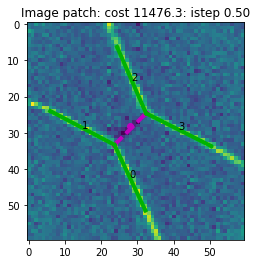

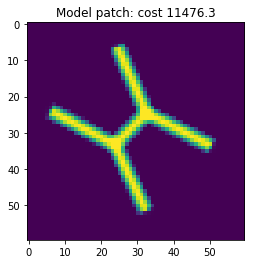

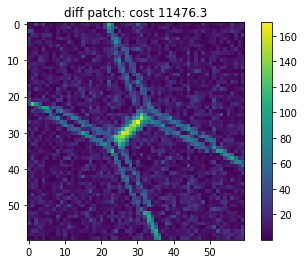

evaluateCross: cost 11476.3126


In [7]:
       t0 = time.time()
res = qtt.deprecated.linetools.fitModel(param0e, imx, verbose=1, cfig=10, istep=istep, istepmodel=istepmodel, ksizemv=ksizemv)
param = res.x
dt = time.time() - t0
print('calculation time: %.2f [s]' % dt)

cost, patch, cdata, _ = evaluateCross(param, imx, verbose=1, fig=25, istep=istep, istepmodel=istepmodel, linewidth=4)

## Show orthogonal line (for polarization scan)

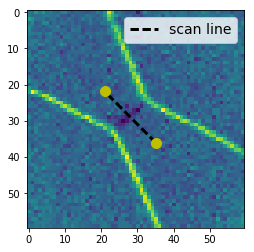

In [8]:
showIm(patch, fig=25)
ppV, ccV, slopeV = linetools.Vtrace(cdata, param, fig=25)